In [1]:
#importing all necessary modules
import os
import warnings
import math
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score, f1_score,confusion_matrix, accuracy_score, classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler, normalize
from scipy import ndimage
import seaborn as sns

In [3]:
#uploading train file
from google.colab import files
uploaded = files.upload()
train_file = next(iter(uploaded))

Saving final_train_file_575_samples.csv to final_train_file_575_samples.csv


In [4]:
#importing test file
from google.colab import files
uploaded = files.upload()
test_file = next(iter(uploaded))

Saving final_test_file_227_samples.csv to final_test_file_227_samples.csv


In [5]:
# Turning the csv files to dataframes
train_data = pd.read_csv(train_file)
test_data = pd.read_csv(test_file)

In [18]:
model_train_data = train_data.drop(columns=['Star_ID', 'Unnamed: 0', 'flux__has_duplicate', 'flux__range_count__max_1__min_-1', 'flux__range_count__max_0__min_-1000000000000.0', 'flux__linear_trend__attr_"pvalue"', 'time__number_cwt_peaks__n_1', 'time__number_cwt_peaks__n_5'])
model_test_data = test_data.drop(columns=['Star_ID', 'flux__range_count__max_1__min_-1', 'flux__range_count__max_0__min_-1000000000000.0', 'flux__linear_trend__attr_"pvalue"', 'time__number_cwt_peaks__n_1', 'time__number_cwt_peaks__n_5', 'flux__symmetry_looking__r_0.1', 'flux__symmetry_looking__r_0.15000000000000002'])

In [19]:
model_train_data = model_train_data.loc[:, model_train_data.nunique() > 1]
model_test_data = model_test_data.loc[:, model_test_data.nunique() > 1]

In [20]:
X = model_train_data.drop(columns=['Exoplanet_Actual'])
y = model_train_data['Exoplanet_Actual']

In [21]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_test = model_test_data.iloc[:,:]
X_train.shape, X_val.shape, X_test.shape

((460, 1425), (115, 1425), (227, 1425))

In [ ]:
# smote = SMOTE(random_state=42)
# X_train, y_train = smote.fit_resample(X_train, y_train)

# X_train.shape, X_test.shape

Text(0.5, 1.0, 'Class Distributions \n (0: Not Exoplanet || 1: Exoplanet)')

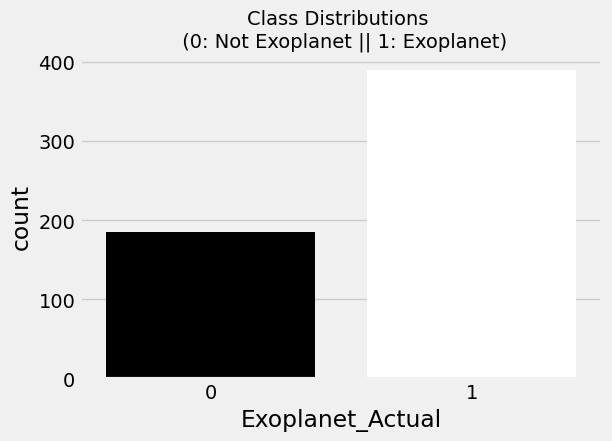

In [22]:
#show difference in number of data points in train file
plt.figure(figsize=(6,4))
colors = ["0", "1"]
sns.countplot(x='Exoplanet_Actual', data=train_data, palette=colors) # Changed: Explicitly specify 'x'
plt.title('Class Distributions \n (0: Not Exoplanet || 1: Exoplanet)', fontsize=14)

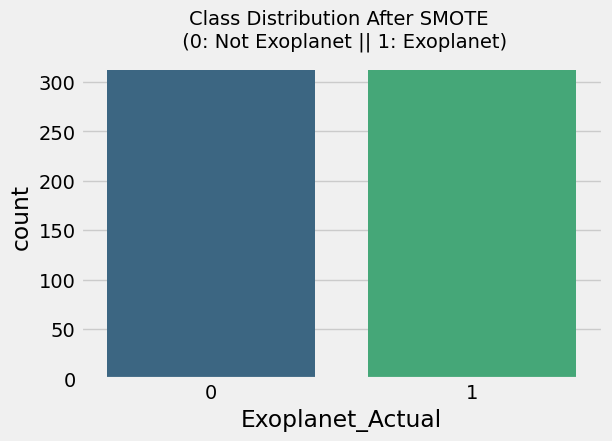

In [23]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

resampled_data = pd.DataFrame({'Exoplanet_Actual': y_train_resampled})

plt.figure(figsize=(6, 4))
sns.countplot(x='Exoplanet_Actual', data=resampled_data, palette='viridis')
plt.title('Class Distribution After SMOTE \n (0: Not Exoplanet || 1: Exoplanet)', fontsize=14)
plt.show()

In [24]:
X_train = pd.DataFrame(X_train, columns=model_train_data.drop(columns=['Exoplanet_Actual']).columns)
X_test = pd.DataFrame(X_test, columns=model_test_data.columns)

print("Features in X_train but missing in X_test:", set(X_train.columns) - set(X_test.columns))
print("Features in X_test but missing in X_train:", set(X_test.columns) - set(X_train.columns))

Features in X_train but missing in X_test: set()
Features in X_test but missing in X_train: set()


In [25]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_resampled)
X_val = scaler.transform(X_val)  # Ensure validation data is also scaled
X_test = scaler.transform(X_test)

In [26]:
from tensorflow import keras
from tensorflow.keras import layers, regularizers, callbacks
from tensorflow.keras.layers import GaussianNoise

model = keras.Sequential([
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    layers.Dropout(0.2),  # Increase dropout

    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),

    layers.Dense(1, activation='sigmoid')
])
# Class weighting to address imbalance
# class_weight =  {0: 1, 1: 1.5}

In [34]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001, weight_decay=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy', 'AUC', 'Precision', 'Recall']
)

In [35]:
history = model.fit(
    X_train, y_train_resampled,
    validation_data=(X_val, y_val),
    epochs=40,
    batch_size=32,
    # class_weight=class_weight,  # Apply class weighting
    verbose=1
)

Epoch 1/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 74ms/step - AUC: 0.9923 - Precision: 0.9524 - Recall: 0.9417 - accuracy: 0.9457 - loss: 0.2557 - val_AUC: 0.7919 - val_Precision: 0.8267 - val_Recall: 0.7949 - val_accuracy: 0.7478 - val_loss: 1.0491
Epoch 2/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - AUC: 0.9964 - Precision: 0.9723 - Recall: 0.9613 - accuracy: 0.9670 - loss: 0.2164 - val_AUC: 0.8257 - val_Precision: 0.8714 - val_Recall: 0.7821 - val_accuracy: 0.7739 - val_loss: 0.9724
Epoch 3/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - AUC: 0.9845 - Precision: 0.9481 - Recall: 0.9389 - accuracy: 0.9495 - loss: 0.2952 - val_AUC: 0.8259 - val_Precision: 0.8500 - val_Recall: 0.8718 - val_accuracy: 0.8087 - val_loss: 0.8871
Epoch 4/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - AUC: 0.9941 - Precision: 0.9697 - Recall: 0.9846 - accuracy: 0.9766 - loss: 0.2276 - val_AUC: 0.8617 - val_Precision: 0.8514 - val_Recall: 0.8077 - val_accuracy: 0.7739 - val_loss: 0.8136
Epoch 5/40
20/20 ━━━━━━━━━━━━━━━━━━━

In [36]:
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]

In [55]:
y_pred_val_prob = model.predict(X_val)  # Probabilities
y_pred_val = (y_pred_val_prob > 0.5).astype(int)  # Convert to binary labels
y_pred_val.flatten()
y_pred_val.shape

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


(115, 1)

In [56]:
precision, recall, f1, _ = classification_report(y_val, y_pred_val, output_dict=True)['1'].values()
roc_auc = roc_auc_score(y_val, y_pred_val_prob)  # AUC-ROC Score
conf_matrix = confusion_matrix(y_val, y_pred_val)

In [57]:
print(f"Final Training Accuracy: {final_train_acc:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"AUC-ROC Score: {roc_auc:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

Final Training Accuracy: 0.9808
Final Validation Accuracy: 0.8435
Precision: 0.8846
Recall: 0.8846
F1-score: 0.8846
AUC-ROC Score: 0.8701
Confusion Matrix:
[[28  9]
 [ 9 69]]


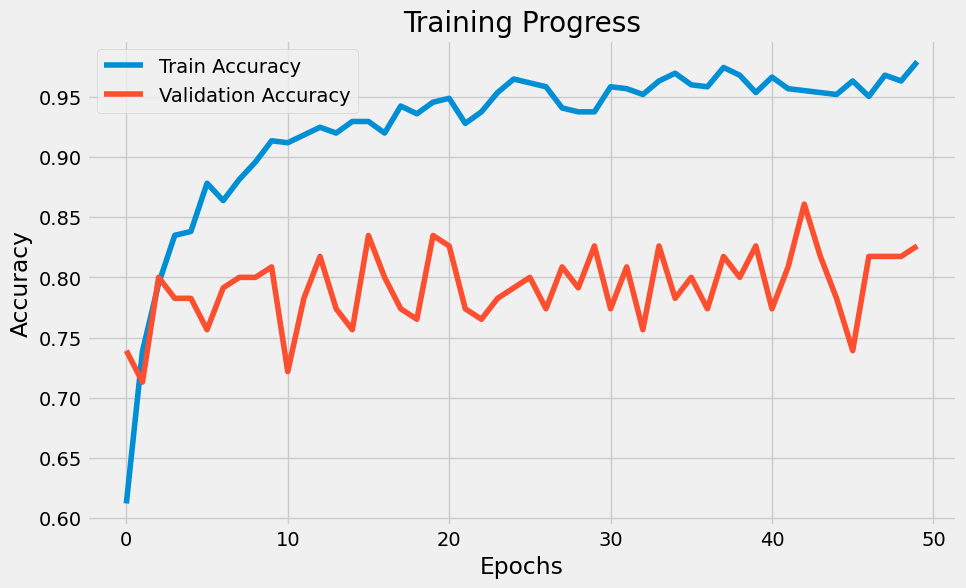

In [33]:
# Plot training history
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training Progress')

plt.show()

In [58]:
y_test_pred_prob = model.predict(X_test)
y_test_pred = (y_test_pred_prob > 0.5).astype(int).flatten()

star_ids_test = test_data['Star_ID']  # Ensure correct IDs

# Ensure no shape mismatch
assert len(y_test_pred) == len(star_ids_test), "Mismatch in test predictions and Star_IDs!"

output = pd.DataFrame({'Star_ID': star_ids_test, 'Prediction': y_test_pred})
output.to_csv('predictions.csv', index=False)
print("Predictions saved successfully!")

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Predictions saved successfully!
